In [15]:
# --------------------------
# 1. Import Required Libraries
# --------------------------
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (classification_report, roc_auc_score, 
                             ConfusionMatrixDisplay, RocCurveDisplay)

# --------------------------
# 2. Load and Prepare Data
# --------------------------
# Load data
file_path = r"C:\Users\hp\Desktop\work\cancer.xlsx"

try:
    # Read the Excel file
    df = pd.read_excel(file_path, engine='openpyxl')
    
    # Display confirmation and preview
    print("✅ File loaded successfully!")
    print(f"\n📊 Dataset preview (shape: {df.shape}):")
    print(df.head())
    
    # Basic dataset info
    print("\nℹ️ Dataset summary:")
    print(df.info())

except FileNotFoundError:
    print(f"❌ Error: File not found at {file_path}. Please check:")
    print("1. File path spelling")
    print("2. File existence at location")
    print("3. File permissions")

except Exception as e:
    print(f"❗ An unexpected error occurred: {str(e)}")

✅ File loaded successfully!

📊 Dataset preview (shape: (73, 32)):
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430 

In [17]:
# Preprocess
df = df.drop(columns=['id'], axis=1)  # ID column isn't useful for modeling
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])  # M=1, B=0


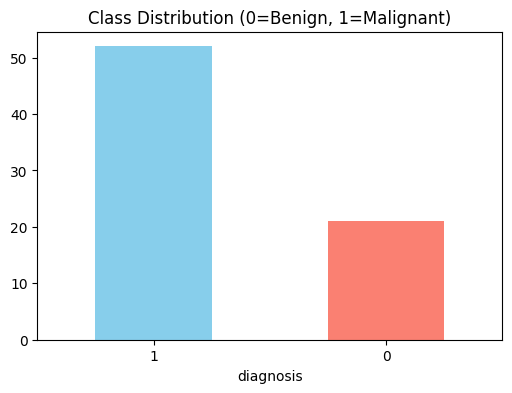

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df['diagnosis'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution (0=Benign, 1=Malignant)')
plt.xticks(rotation=0)
plt.show()

In [23]:
# --------------------------
# 3. Train-Test Split
# --------------------------
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
# --------------------------
# 4. Model Setup
# --------------------------
# Calculate class weight for XGBoost
scale_pos_weight = len(y_train[y_train==0])/len(y_train[y_train==1])

# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=scale_pos_weight, 
                            eval_metric='logloss', use_label_encoder=False),
    "SVM": SVC(class_weight='balanced', probability=True, random_state=42)
}

In [27]:
# --------------------------
# 5. Model Comparison
# --------------------------
print("\n🔍 Model Comparison (5-fold cross-validation ROC-AUC):")
model_scores = {}

for name, model in models.items():
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, 
                            cv=5, scoring='roc_auc', n_jobs=-1)
    model_scores[name] = {
        'mean_score': scores.mean(),
        'std_score': scores.std()
    }
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")



🔍 Model Comparison (5-fold cross-validation ROC-AUC):
Logistic Regression: 0.994 ± 0.012
Random Forest: 0.983 ± 0.033
XGBoost: 0.983 ± 0.033
SVM: 0.992 ± 0.017


In [29]:
# --------------------------
# 6. Best Model Selection & Tuning
# --------------------------
best_model_name = max(model_scores, key=lambda x: model_scores[x]['mean_score'])
best_model = models[best_model_name]
print(f"\n🏆 Best Model: {best_model_name}")

# Hyperparameter grid
param_grids = {
    "Logistic Regression": {'model__C': [0.1, 1, 10], 'model__solver': ['lbfgs', 'liblinear']},
    "Random Forest": {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10]},
    "XGBoost": {'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 5], 'model__n_estimators': [100, 200]},
    "SVM": {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}
}

# Tuning
tuned_pipeline = GridSearchCV(
    ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', best_model)
    ]),
    param_grids[best_model_name],
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

tuned_pipeline.fit(X_train, y_train)



🏆 Best Model: Logistic Regression


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10],
                         'model__solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc')

In [31]:
# --------------------------
# 7. Final Evaluation
# --------------------------
print(f"\n📊 Best Parameters: {tuned_pipeline.best_params_}")
final_model = tuned_pipeline.best_estimator_

# Test set evaluation
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("\n📈 Final Evaluation:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.3f}")


📊 Best Parameters: {'model__C': 0.1, 'model__solver': 'liblinear'}

📈 Final Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

ROC-AUC Score: 1.000


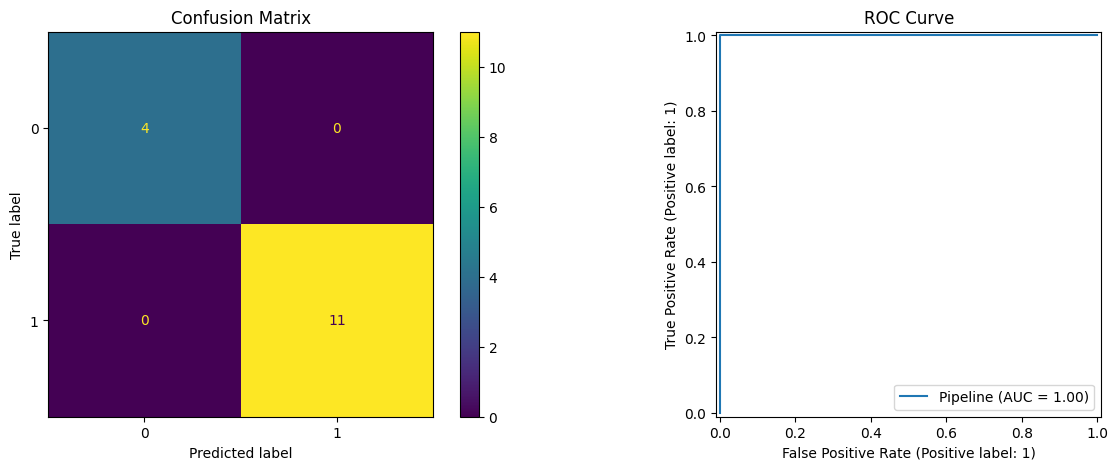

In [33]:
# --------------------------
# 8. Visualizations
# --------------------------
# Confusion Matrix & ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test, ax=ax[0])
ax[0].set_title("Confusion Matrix")

RocCurveDisplay.from_estimator(final_model, X_test, y_test, ax=ax[1])
ax[1].set_title("ROC Curve")
plt.show()

# Feature Importance (for tree-based models)
if best_model_name in ["Random Forest", "XGBoost"]:
    plt.figure(figsize=(10, 6))
    if best_model_name == "XGBoost":
        importances = final_model.named_steps['model'].feature_importances_
    else:
        importances = final_model.named_steps['model'].feature_importances_
        
    feat_importances = pd.Series(importances, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title("Top 10 Important Features")
    plt.show()

In [35]:
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
# Expected: ~58 train, 15 test samples

Train size: 58, Test size: 15


In [37]:
# Verify no duplicate IDs between train/test
train_ids = X_train.index.tolist()
test_ids = X_test.index.tolist()
print(f"Overlapping samples: {len(set(train_ids) & set(test_ids))}")

Overlapping samples: 0


In [39]:
import joblib

# Save the entire pipeline (including scaler and model)
joblib.dump(final_model, 'breast_cancer_model.pkl')

# Optional: Save the label encoder if needed
joblib.dump(le, 'label_encoder.pkl')



['label_encoder.pkl']

In [65]:



# Save model artifacts
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']

In [67]:
# Save feature names
feature_names = list(X_train.columns)
joblib.dump(feature_names, 'feature_names.pkl')

['feature_names.pkl']

In [ ]:
# Save model artifacts
joblib.dump(X_test, 'X_test.pkl')